In [8]:
!pip install pandas openpyxl
import pandas as pd

In [9]:
df = pd.read_csv('IMBD.csv')
df

,movie,genre,runtime,certificate,rating,stars,description,votes,director
0,The Witcher,"Action, Adventure, Drama",60 min,A,8.1,"['Henry Cavill, ', 'Freya Allan, ', 'Anya Chal...","Geralt of Rivia, a solitary monster hunter, st...","5,39,085",NaN
1,Mission: Impossible - Dead Reckoning Part One,"Action, Adventure, Thriller",163 min,UA,8.0,"['Tom Cruise, ', 'Hayley Atwell, ', 'Ving Rham...",Ethan Hunt and his IMF team must track down a ...,"1,06,759",['Christopher McQuarrie']
2,Sound of Freedom,"Action, Biography, Drama",131 min,PG-13,7.9,"['Jim Caviezel, ', 'Mira Sorvino, ', 'Bill Cam...",The incredible true story of a former governme...,"41,808",['Alejandro Monteverde']
3,Secret Invasion,"Action, Adventure, Drama",47 min,UA 16+,6.2,"['Samuel L. Jackson, ', 'Emilia Clarke, ', 'Do...",Fury and Talos try to stop the Skrulls who hav...,"40,536",NaN
4,Special Ops: Lioness,"Action, Drama, Thriller",NaN,NaN,7.5,"['Zoe Saldana, ', 'Laysla De Oliveira, ', 'Dav...",Joe attempts to balance her personal and profe...,"3,203",NaN
...,...,...,...,...,...,...,...,...,...
129886,Chocatos,"Short, Drama, Family",10 min,NaN,NaN,NaN,Add a Plot\n,NaN,['Diego Al Romero']
129887,Song of the Caballero,"Drama, Western",73 min,NaN,NaN,"['Ken Maynard, ', 'Doris Hill, ', 'Francis For...",After El Lobo robs Don Jose he gives one of th...,NaN,['Harry Joe Brown']
129888,The Flaming Forties,Western,60 min,NaN,NaN,"['Harry Carey, ', 'William Bailey, ', 'Jacquel...",A young cowhand befriends a disreputable gambl...,NaN,['Tom Forman']
129889,The Girl and the Sheriff,"Short, Western",NaN,NaN,NaN,"['Betty Keller, ', 'George Field, ', 'Lee Mora...","Bob Warren, sheriff of Grass County, Cal., and...",NaN,['Al Christie']


In [10]:
df.head()

,movie,genre,runtime,certificate,rating,stars,description,votes,director
0,The Witcher,"Action, Adventure, Drama",60 min,A,8.1,"['Henry Cavill, ', 'Freya Allan, ', 'Anya Chal...","Geralt of Rivia, a solitary monster hunter, st...","5,39,085",NaN
1,Mission: Impossible - Dead Reckoning Part One,"Action, Adventure, Thriller",163 min,UA,8.0,"['Tom Cruise, ', 'Hayley Atwell, ', 'Ving Rham...",Ethan Hunt and his IMF team must track down a ...,"1,06,759",['Christopher McQuarrie']
2,Sound of Freedom,"Action, Biography, Drama",131 min,PG-13,7.9,"['Jim Caviezel, ', 'Mira Sorvino, ', 'Bill Cam...",The incredible true story of a former governme...,"41,808",['Alejandro Monteverde']
3,Secret Invasion,"Action, Adventure, Drama",47 min,UA 16+,6.2,"['Samuel L. Jackson, ', 'Emilia Clarke, ', 'Do...",Fury and Talos try to stop the Skrulls who hav...,"40,536",NaN
4,Special Ops: Lioness,"Action, Drama, Thriller",NaN,NaN,7.5,"['Zoe Saldana, ', 'Laysla De Oliveira, ', 'Dav...",Joe attempts to balance her personal and profe...,"3,203",NaN


In [11]:
# imdb_make_csvs.py
# Create normalized CSVs from IMBD.csv for MySQL
# Outputs: movies.csv, genres.csv, movie_genres.csv, directors.csv, movie_directors.csv, stars.csv, movie_stars.csv

import pandas as pd
import numpy as np
import re
import ast
from pathlib import Path

SRC = "IMBD.csv"         # path to your raw IMDb CSV
OUTDIR = Path(".")       # output folder (use "." for current)

# ---------- Helpers ----------
def clean_runtime(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r"\d+", str(x))
    return int(m.group()) if m else np.nan

def clean_votes(x):
    if pd.isna(x):
        return np.nan
    s = re.sub(r"[^\d]", "", str(x))
    return int(s) if s.isdigit() else np.nan

def clean_text(s):
    if pd.isna(s):
        return ""
    return str(s).strip()

def parse_listlike(cell):
    """Parse list-like strings like "['A', 'B']" or comma strings into a list of clean strings."""
    if pd.isna(cell):
        return []
    s = str(cell).strip()
    # try literal list first
    if s.startswith("[") and s.endswith("]"):
        try:
            vals = ast.literal_eval(s)
            return [clean_text(v).strip(",") for v in vals if clean_text(v)]
        except Exception:
            pass
    # fallback: split by comma
    return [clean_text(v).strip(",") for v in s.split(",") if clean_text(v)]

# ---------- Load ----------
df = pd.read_csv(SRC)

# ---------- Movies table ----------
movies = pd.DataFrame({
    "movie": df["movie"].astype(str).str.strip(),
    "runtime_mins": df.get("runtime", np.nan).apply(clean_runtime),
    "certificate": df.get("certificate", "").astype(str).replace("nan", "").str.strip(),
    "rating": pd.to_numeric(df.get("rating", np.nan), errors="coerce"),
    "votes_num": df.get("votes", np.nan).apply(clean_votes),
    "description": df.get("description", "").astype(str).str.strip()
})

# Drop exact duplicate titles to keep one canonical row
movies = movies.drop_duplicates(subset=["movie"]).reset_index(drop=True)
movies.insert(0, "movie_id", range(1, len(movies) + 1))

# ---------- Genres (M:N) ----------
# Source genre column may be comma-separated
genre_rows = []
if "genre" in df.columns:
    tmp = df[["movie", "genre"]].dropna(subset=["movie"])
    for _, row in tmp.iterrows():
        movie_name = clean_text(row["movie"])
        for g in [v for v in str(row["genre"]).split(",") if clean_text(v)]:
            genre_rows.append({"movie": movie_name, "genre_name": clean_text(g)})

genres_df = pd.DataFrame(genre_rows)
if not genres_df.empty:
    genres = pd.DataFrame(
        {"genre_name": sorted(genres_df["genre_name"].dropna().unique())}
    ).reset_index(drop=True)
    genres.insert(0, "genre_id", range(1, len(genres) + 1))
else:
    genres = pd.DataFrame(columns=["genre_id", "genre_name"])

# Map titles → ids
movie_id_map = movies.set_index("movie")["movie_id"].to_dict()

# Bridge table movie_genres
if not genres_df.empty:
    genre_id_map = genres.set_index("genre_name")["genre_id"].to_dict()
    mg = genres_df.copy()
    mg["movie_id"] = mg["movie"].map(movie_id_map)
    mg["genre_id"] = mg["genre_name"].map(genre_id_map)
    movie_genres = mg[["movie_id", "genre_id"]].dropna().drop_duplicates().reset_index(drop=True)
else:
    movie_genres = pd.DataFrame(columns=["movie_id", "genre_id"])

# ---------- Directors (M:N) ----------
directors_rows = []
if "director" in df.columns:
    tmp = df[["movie", "director"]].dropna(subset=["movie"])
    for _, row in tmp.iterrows():
        movie_name = clean_text(row["movie"])
        for d in parse_listlike(row["director"]):
            if d:
                directors_rows.append({"movie": movie_name, "director_name": d})

directors_df = pd.DataFrame(directors_rows)
if not directors_df.empty:
    directors = pd.DataFrame(
        {"director_name": sorted(directors_df["director_name"].dropna().unique())}
    ).reset_index(drop=True)
    directors.insert(0, "director_id", range(1, len(directors) + 1))
    director_id_map = directors.set_index("director_name")["director_id"].to_dict()

    md = directors_df.copy()
    md["movie_id"] = md["movie"].map(movie_id_map)
    md["director_id"] = md["director_name"].map(director_id_map)
    movie_directors = md[["movie_id", "director_id"]].dropna().drop_duplicates().reset_index(drop=True)
else:
    directors = pd.DataFrame(columns=["director_id", "director_name"])
    movie_directors = pd.DataFrame(columns=["movie_id", "director_id"])

# ---------- Stars (M:N, optional) ----------
stars_rows = []
if "stars" in df.columns:
    tmp = df[["movie", "stars"]].dropna(subset=["movie"])
    for _, row in tmp.iterrows():
        movie_name = clean_text(row["movie"])
        for s in parse_listlike(row["stars"]):
            if s:
                stars_rows.append({"movie": movie_name, "star_name": s})

stars_df = pd.DataFrame(stars_rows)
if not stars_df.empty:
    stars = pd.DataFrame(
        {"star_name": sorted(stars_df["star_name"].dropna().unique())}
    ).reset_index(drop=True)
    stars.insert(0, "star_id", range(1, len(stars) + 1))
    star_id_map = stars.set_index("star_name")["star_id"].to_dict()

    ms = stars_df.copy()
    ms["movie_id"] = ms["movie"].map(movie_id_map)
    ms["star_id"] = ms["star_name"].map(star_id_map)
    movie_stars = ms[["movie_id", "star_id"]].dropna().drop_duplicates().reset_index(drop=True)
else:
    stars = pd.DataFrame(columns=["star_id", "star_name"])
    movie_stars = pd.DataFrame(columns=["movie_id", "star_id"])

# ---------- Write CSVs ----------
def save(dfout, name):
    path = OUTDIR / name
    dfout.to_csv(path, index=False, encoding="utf-8")
    print(f"Saved {name}: {len(dfout)} rows")

save(movies, "movies.csv")
save(genres, "genres.csv")
save(movie_genres, "movie_genres.csv")
save(directors, "directors.csv")
save(movie_directors, "movie_directors.csv")
save(stars, "stars.csv")               # optional
save(movie_stars, "movie_stars.csv")   # optional

# ---------- Summary ----------
print("\nSummary:")
print(f"Movies           : {len(movies)}")
print(f"Genres           : {len(genres)} | Links (movie_genres): {len(movie_genres)}")
print(f"Directors        : {len(directors)} | Links (movie_directors): {len(movie_directors)}")
print(f"Stars (optional) : {len(stars)} | Links (movie_stars): {len(movie_stars)}")


Saved movies.csv: 115988 rows
Saved genres.csv: 28 rows
Saved movie_genres.csv: 281691 rows
Saved directors.csv: 39519 rows
Saved movie_directors.csv: 86361 rows
Saved stars.csv: 197864 rows
Saved movie_stars.csv: 462111 rows

Summary:
Movies           : 115988
Genres           : 28 | Links (movie_genres): 281691
Directors        : 39519 | Links (movie_directors): 86361
Stars (optional) : 197864 | Links (movie_stars): 462111


In [12]:
from urllib.parse import quote_plus
from sqlalchemy import create_engine, text

user = "root"
pw   = quote_plus("Fahrscheine1!")  # URL-encode special chars
host = "127.0.0.1"
port = 3306
db   = "imdb_project"

url = f"mysql+pymysql://{user}:{pw}@{host}:{port}/{db}?charset=utf8mb4"
engine = create_engine(url, future=True)

# quick test
with engine.connect() as conn:
    print(conn.execute(text("SELECT 1")).scalar())


1


CWD: c:\Users\ruchi\Documents\Python_ironhack\week4\project-4
Python exe: c:\Users\ruchi\anaconda3\python.exe
Rows returned: 10

Saved figure to: C:\Users\ruchi\Documents\Python_ironhack\week4\project-4\plots\top10_genres_by_avg_rating.png
File exists: True | Size: 40655 bytes


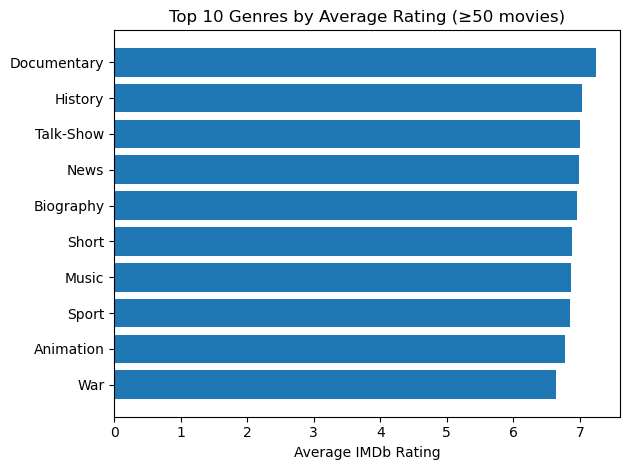

In [27]:
from pathlib import Path
import os, sys
import pandas as pd
import matplotlib.pyplot as plt

print("CWD:", os.getcwd())
print("Python exe:", sys.executable)

# --- query: top 10 genres by avg rating (>=50 titles) ---
q = """
SELECT g.genre_name,
       AVG(m.rating) AS avg_rating,
       COUNT(*)      AS n_movies
FROM movies m
JOIN movie_genres mg ON m.movie_id = mg.movie_id
JOIN genres g        ON mg.genre_id = g.genre_id
WHERE m.rating IS NOT NULL
GROUP BY g.genre_name
HAVING COUNT(*) >= 50
ORDER BY avg_rating DESC
LIMIT 10;
"""
df = pd.read_sql(q, engine)
print("Rows returned:", len(df))
if df.empty:
    raise SystemExit("No rows to plot — check that the DB has data.")

# --- plot ---
fig, ax = plt.subplots()
ax.barh(df["genre_name"], df["avg_rating"])
ax.invert_yaxis()
ax.set_xlabel("Average IMDb Rating")
ax.set_title("Top 10 Genres by Average Rating (≥50 movies)")
fig.tight_layout()

# --- ABSOLUTE save path (points to your repo folder) ---
BASE_DIR = Path(r"C:\Users\ruchi\Documents\Python_ironhack\week4\project-4")
PLOTS_DIR = BASE_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

out_path = PLOTS_DIR / "top10_genres_by_avg_rating.png"

# Save BEFORE show, then verify
fig.savefig(out_path, dpi=150, bbox_inches="tight")
exists = out_path.exists()
size = out_path.stat().st_size if exists else 0
print(f"\nSaved figure to: {out_path}")
print(f"File exists: {exists} | Size: {size} bytes")

# Auto-open the folder in File Explorer (Windows)
os.startfile(str(PLOTS_DIR))

plt.show()


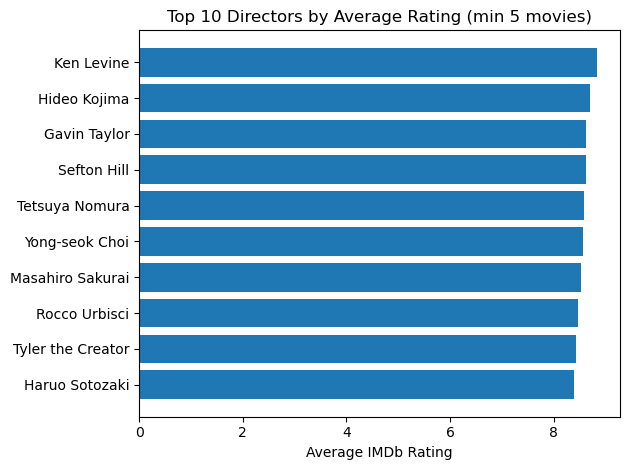

Saved figure to: C:\Users\ruchi\Documents\Python_ironhack\week4\project\plots\top10_directors_avg_rating.png
File exists: True | Size: 50266 bytes


In [18]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# --- query (unchanged) ---
q_directors = """
SELECT d.director_name,
       AVG(m.rating) AS avg_rating,
       COUNT(*)      AS n_movies
FROM movies m
JOIN movie_directors md ON m.movie_id = md.movie_id
JOIN directors d       ON md.director_id = d.director_id
WHERE m.rating IS NOT NULL
GROUP BY d.director_name
HAVING COUNT(*) >= 5
ORDER BY avg_rating DESC
LIMIT 10;
"""
df_dir = pd.read_sql(q_directors, engine)

# --- plot ---
plt.figure()
plt.barh(df_dir["director_name"], df_dir["avg_rating"])
plt.gca().invert_yaxis()
plt.xlabel("Average IMDb Rating")
plt.title("Top 10 Directors by Average Rating (min 5 movies)")
plt.tight_layout()

# --- absolute path (EDIT THIS ROOT IF NEEDED) ---
PROJECT_DIR = Path(r"C:\Users\ruchi\Documents\Python_ironhack\week4\project")
PLOTS_DIR = PROJECT_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

out_path = PLOTS_DIR / "top10_directors_avg_rating.png"

# save BEFORE show
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()

# verify + print where it went
exists = out_path.exists()
size = out_path.stat().st_size if exists else 0
print(f"Saved figure to: {out_path}")
print(f"File exists: {exists} | Size: {size} bytes")

# OPTIONAL: open the folder in File Explorer
# os.startfile(str(PLOTS_DIR))


Saved figure to: C:\Users\ruchi\Documents\Python_ironhack\week4\project\plots\top10_genres_by_count.png


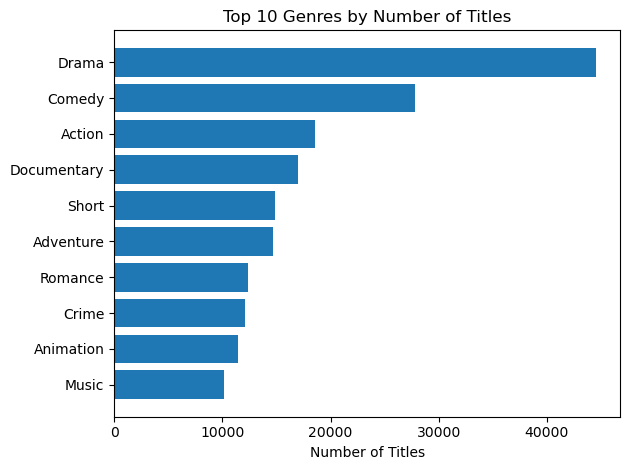

In [20]:
q_genre_count = """
SELECT g.genre_name,
       COUNT(*) AS n_titles
FROM movie_genres mg
JOIN genres g ON mg.genre_id = g.genre_id
GROUP BY g.genre_name
ORDER BY n_titles DESC
LIMIT 10;
"""
df_gcount = pd.read_sql(q_genre_count, engine)

plt.figure()
plt.barh(df_gcount["genre_name"], df_gcount["n_titles"])
plt.gca().invert_yaxis()
plt.xlabel("Number of Titles")
plt.title("Top 10 Genres by Number of Titles")
plt.tight_layout()

from pathlib import Path

# --- save to disk (absolute path; edit root if needed) ---
PROJECT_DIR = Path(r"C:\Users\ruchi\Documents\Python_ironhack\week4\project")
PLOTS_DIR = PROJECT_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

out_path = PLOTS_DIR / "top10_genres_by_count.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight")  # save BEFORE show


print(f"Saved figure to: {out_path}")
# Optional: open the folder automatically (Windows only)
# import os; os.startfile(str(PLOTS_DIR))

plt.show()

Rows returned: 13
Saved figure to: C:\Users\ruchi\Documents\Python_ironhack\week4\project-4\plots\avg_rating_by_certificate.png  (41430 bytes)


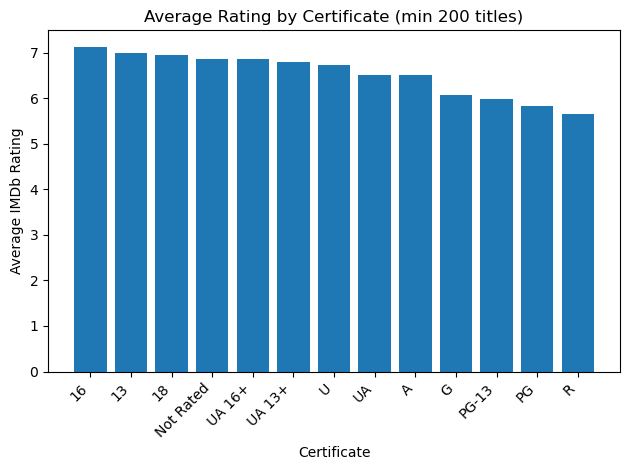

In [30]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# --- query ---
q_cert = """
SELECT certificate,
       AVG(rating) AS avg_rating,
       COUNT(*)    AS n_titles
FROM movies
WHERE rating IS NOT NULL
  AND certificate IS NOT NULL
  AND certificate <> ''
GROUP BY certificate
HAVING COUNT(*) >= 200
ORDER BY avg_rating DESC;
"""
df_cert = pd.read_sql(q_cert, engine)
print("Rows returned:", len(df_cert))

if df_cert.empty:
    print("No rows to plot — check data/query.")
else:
    # --- plot ---
    fig, ax = plt.subplots()
    ax.bar(df_cert["certificate"], df_cert["avg_rating"])  # keep simple; optional color if you like
    ax.set_xlabel("Certificate")
    ax.set_ylabel("Average IMDb Rating")
    ax.set_title("Average Rating by Certificate (min 200 titles)")
    plt.xticks(rotation=45, ha="right")
    fig.tight_layout()

    # --- save (absolute path; edit base path if needed) ---
    PROJECT_DIR = Path(r"C:\Users\ruchi\Documents\Python_ironhack\week4\project-4")
    PLOTS_DIR = PROJECT_DIR / "plots"
    PLOTS_DIR.mkdir(parents=True, exist_ok=True)

    out_path = PLOTS_DIR / "avg_rating_by_certificate.png"
    fig.savefig(out_path, dpi=150, bbox_inches="tight")   # SAVE BEFORE show
    print(f"Saved figure to: {out_path}  ({out_path.stat().st_size} bytes)")

    plt.show()
    # Optional: open the folder automatically on Windows
    # import os; os.startfile(str(PLOTS_DIR))
